In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Dot, Activation, Conv1D, LayerNormalization
from tensorflow.keras.layers import Dense, TimeDistributed, RepeatVector, Add, concatenate
sns.set()

**Quick Instruction Note**

1.   The input and ouput both are sequences of 5 items. The first two items of the ouput are the same as the input: input = [37,38,13,3,11], output = [37,38,0,0,0]
2.   The input and output are one-hot encoded and so the input shape of the model is (batch_size, timesteps=5, feature=50) since there are 5 items and the item values are from 0 to 50
3.   Since the model is seq2seq, thus the attention map's size is (timesteps*timesteps) and it is generated using query and key. The attention map is then multipled with the value to get the content vector
4.   https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/




# **Original Model**

In [0]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]
 
# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)
 
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]
 
# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
	# generate random sequence
	sequence_in = generate_sequence(n_in, cardinality)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, cardinality)
	y = one_hot_encode(sequence_out, cardinality)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y
 
# define the encoder-decoder model
def baseline_model(n_timesteps_in, n_features):
  input_ = Input(shape=(n_timesteps_in, n_features))
  x = LSTM(150)(input_)
  x = RepeatVector(n_timesteps_in)(x)
  x = LSTM(150, return_sequences=True)(x)
  output_ = TimeDistributed(Dense(n_features, activation="softmax"))(x)
  model = Model(inputs=input_, outputs=output_)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	#model = Sequential()
	#model.add(LSTM(150, input_shape=(n_timesteps_in, n_features)))
	#model.add(RepeatVector(n_timesteps_in))
	#model.add(LSTM(150, return_sequences=True))
	#model.add(TimeDistributed(Dense(n_features, activation='softmax')))
  return model

# My own attention model
# define the encoder-decoder with attention model
def attention_model(n_timesteps_in, n_features):
  input_ = Input(shape=(n_timesteps_in, n_features))
  x = LSTM(150, return_sequences=True)(input_)

  # Create query, key, value for self-attention computation
  # Conv1D with kernel_size 1 is equal to Dense
  query = Conv1D(filters=32, kernel_size=1, activation="relu", strides=1)(x)
  key = Conv1D(filters=32, kernel_size=1, activation="relu", strides=1)(x)
  value = Conv1D(filters=64, kernel_size=1, activation="relu", strides=1)(x)
  # Dot product query and key - the query_key's size should be (timesteps * timesteps)
  # axes: indicate the axes to multiply with the other tensor
  query_key = Dot(axes=2, normalize=True)([query,key]) 
  # Softmax is applied across the columns to find the attention of one timestep to the others
  # The attention's size should be (timesteps * timesteps)
  attention = Activation("softmax")(query_key)
  content_vector = Dot(axes=1, normalize=True, name="reg_dot2")([attention,value])

  output_ = Dense(n_features, activation="softmax")(content_vector)
  model = Model(inputs=input_, outputs=output_)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model
 
# train and evaluate a model, return accuracy
def train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs):
	# train LSTM
	for epoch in range(epochs):
		# generate new random sequence
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		# fit model for one epoch on this sequence
		model.fit(X, y, epochs=1, verbose=0)
	# evaluate LSTM
	total, correct = 100, 0
	for _ in range(total):
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		yhat = model.predict(X, verbose=0)
		if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
			correct += 1
	return float(correct)/float(total)*100.0
 
# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_repeats = 10
epochs = 20000
# evaluate encoder-decoder model
print('Encoder-Decoder Model')
results = list()

model = baseline_model(n_timesteps_in, n_features)
model.summary()
#accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs)
#results.append(accuracy)
#print(accuracy)

model = attention_model(n_timesteps_in, n_features)
model.summary()
#accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs)
#results.append(accuracy)
#print(accuracy)

Encoder-Decoder Model
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 5, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 150)               120600    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 5, 150)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 150)            180600    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 50)             7550      
Total params: 308,750
Trainable params: 308,750
Non-trainable params: 0
_________________________________________________________________
Model: "model_6"
________________________________________________________________________________

**5000 Epochs**

In [0]:
# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_repeats = 5
epochs = 5000

# evaluate encoder-decoder model
print('Encoder-Decoder Model')
results = list()
for _ in range(n_repeats):
  model = baseline_model(n_timesteps_in, n_features)
  accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs)
  results.append(accuracy)
  print(accuracy)
print('Mean Accuracy: %.2f%% \n' % (sum(results)/float(n_repeats)))

# evaluate encoder-decoder with attention model
print('Encoder-Decoder With Attention Model')
results = list()
for _ in range(n_repeats):
  model = attention_model(n_timesteps_in, n_features)
  accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs)
  results.append(accuracy)
  print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))

Encoder-Decoder Model
24.0
22.0
23.0
22.0
19.0
Mean Accuracy: 22.00% 

Encoder-Decoder With Attention Model
36.0
47.0
47.0
73.0
92.0
Mean Accuracy: 59.00%


# **Revision Self Attention Model 1 (5000 epochs)**

1.   Adjust the hidden neurons number of query, key and value's layers
2.   Performance improves by double and is more stable



In [0]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]
 
# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)
 
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]
 
# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
	# generate random sequence
	sequence_in = generate_sequence(n_in, cardinality)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, cardinality)
	y = one_hot_encode(sequence_out, cardinality)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y
 
# train and evaluate a model, return accuracy
def train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs):
	# train LSTM
	for epoch in range(epochs):
		# generate new random sequence
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		# fit model for one epoch on this sequence
		model.fit(X, y, epochs=1, verbose=0)
	# evaluate LSTM
	total, correct = 100, 0
	for _ in range(total):
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		yhat = model.predict(X, verbose=0)
		if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
			correct += 1
	return float(correct)/float(total)*100.0

# My own attention model
# define the encoder-decoder with attention model
def attention_model(n_timesteps_in, n_features):
  input_ = Input(shape=(n_timesteps_in, n_features))
  x = LSTM(150, return_sequences=True)(input_)

  # Create query, key, value for self-attention computation
  # Conv1D with kernel_size 1 is equal to Dense
  query = Conv1D(filters=75, kernel_size=1, activation="relu", strides=1)(x)
  key = Conv1D(filters=75, kernel_size=1, activation="relu", strides=1)(x)
  value = Conv1D(filters=150, kernel_size=1, activation="relu", strides=1)(x)
  # Dot product query and key - the query_key's size should be (timesteps * timesteps)
  # axes: indicate the axes to multiply with the other tensor
  query_key = Dot(axes=2, normalize=True)([query,key]) 
  # Softmax is applied across the columns to find the attention of one timestep to the others
  # The attention's size should be (timesteps * timesteps)
  attention = Activation("softmax")(query_key)
  content_vector = Dot(axes=1, normalize=True, name="reg_dot2")([attention,value])

  output_ = Dense(n_features, activation="softmax")(content_vector)
  model = Model(inputs=input_, outputs=output_)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_repeats = 5
epochs = 5000

# evaluate encoder-decoder with attention model
print('Encoder-Decoder With Attention Model')
results = list()
for i in range(n_repeats):
  model = attention_model(n_timesteps_in, n_features)
  if i == 0:
    model.summary()
  accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs)
  results.append(accuracy)
  print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))

Encoder-Decoder With Attention Model
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 50)]      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 150)       120600      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 5, 75)        11325       lstm_1[0][0]                     
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 5, 75)        11325       lstm_1[0][0]                     
_______________________________________________________

**Activation Map Visualization**

Model: "Activation_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 5, 50)]      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 5, 150)       120600      input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 5, 75)        11325       lstm_5[0][0]                     
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 5, 75)        11325       lstm_5[0][0]                     
___________________________________________________________________________________

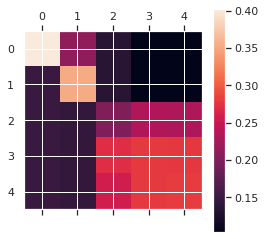

([13, 46, 49, 0, 40], [13, 46, 0, 0, 0], [13, 46, 0, 0, 0])

In [0]:
# For revision model 1
activation_model = Model(inputs=model.input, outputs=model.layers[-4].output, name="Activation_model")
activation_model.summary()

X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
activation = activation_model.predict(X, verbose=0)
yhat = model.predict(X, verbose=0)

fig = plt.matshow(activation[0].transpose())
plt.colorbar(fig)
plt.show()

one_hot_decode(X[0]), one_hot_decode(y[0]), one_hot_decode(yhat[0])

# **Revision Self Attention Model 2 (5000 epochs)**

1.   Adjust the hidden neurons number of query, key and value's layers
2.   Add the original input to the attention layer with the attention output (attention map)
3.   The result is slighty better than that of the revision model 1

In [0]:
# My own attention model
# define the encoder-decoder with attention model
def attention_model(n_timesteps_in, n_features):
 input_ = Input(shape=(n_timesteps_in, n_features))
 x = LSTM(150, return_sequences=True)(input_)

 # Create query, key, value for self-attention computation
 # Conv1D with kernel_size 1 is equal to Dense
 query = Conv1D(filters=75, kernel_size=1, activation="relu", strides=1)(x)
 key = Conv1D(filters=75, kernel_size=1, activation="relu", strides=1)(x)
 value = Conv1D(filters=150, kernel_size=1, activation="relu", strides=1)(x)
 # Dot product query and key - the query_key's size should be (timesteps * timesteps)
 # axes: indicate the axes to multiply with the other tensor
 query_key = Dot(axes=2, normalize=True)([query,key]) 
 # Softmax is applied across the columns to find the attention of one timestep to the others
 # The attention's size should be (timesteps * timesteps)
 attention = Activation("softmax")(query_key)
 content_vector = Dot(axes=1, normalize=True, name="reg_dot2")([attention,value])
 content_vector = Add()([x,content_vector])
 output_ = Dense(n_features, activation="softmax")(content_vector)

 model = Model(inputs=input_, outputs=output_)
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_repeats = 10
epochs = 5000

# evaluate encoder-decoder with attention model
print('Encoder-Decoder With Attention Model')
results = list()
for i in range(n_repeats):
  model = attention_model(n_timesteps_in, n_features)
  if i == 0:
    model.summary()
  accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs)
  results.append(accuracy)
  print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))

Encoder-Decoder With Attention Model
Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 5, 50)        0                                            
__________________________________________________________________________________________________
lstm_53 (LSTM)                  (None, 5, 150)       120600      input_50[0][0]                   
__________________________________________________________________________________________________
conv1d_139 (Conv1D)             (None, 5, 75)        11325       lstm_53[0][0]                    
__________________________________________________________________________________________________
conv1d_140 (Conv1D)             (None, 5, 75)        11325       lstm_53[0][0]                    
______________________________________________________

**Activation Map Visualization**

Model: "Activation_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 5, 50)        0                                            
__________________________________________________________________________________________________
lstm_62 (LSTM)                  (None, 5, 150)       120600      input_59[0][0]                   
__________________________________________________________________________________________________
conv1d_166 (Conv1D)             (None, 5, 75)        11325       lstm_62[0][0]                    
__________________________________________________________________________________________________
conv1d_167 (Conv1D)             (None, 5, 75)        11325       lstm_62[0][0]                    
___________________________________________________________________________________

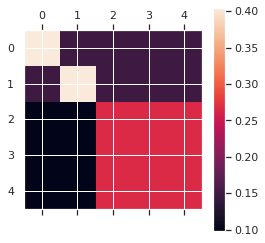

([23, 4, 48, 29, 12], [23, 4, 0, 0, 0], [23, 4, 0, 0, 0])

In [0]:
# For revision model 2
activation_model = Model(inputs=model.input, outputs=model.layers[-5].output, name="Activation_model")
activation_model.summary()

X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
activation = activation_model.predict(X, verbose=0)
yhat = model.predict(X, verbose=0)

fig = plt.matshow(activation[0])
plt.colorbar(fig)
plt.show()

one_hot_decode(X[0]), one_hot_decode(y[0]), one_hot_decode(yhat[0])

# **Revision Self Attention Model 3 (5000 epochs)**

1.   Adjust the hidden neurons number of query, key and value's layers
2.   Add the original input to the attention layer with the attention output (attention map)
3.   Add the layer normalization
4.   Best result among the three models

In [0]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]
 
# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)
 
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]
 
# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
	# generate random sequence
	sequence_in = generate_sequence(n_in, cardinality)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, cardinality)
	y = one_hot_encode(sequence_out, cardinality)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y
 
# train and evaluate a model, return accuracy
def train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs):
	# train LSTM
	for epoch in range(epochs):
		# generate new random sequence
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		# fit model for one epoch on this sequence
		model.fit(X, y, epochs=1, verbose=0)
	# evaluate LSTM
	total, correct = 100, 0
	for _ in range(total):
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		yhat = model.predict(X, verbose=0)
		if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
			correct += 1
	return float(correct)/float(total)*100.0

In [0]:
# My own attention model
# define the encoder-decoder with attention model
def attention_model(n_timesteps_in, n_features):
 input_ = Input(shape=(n_timesteps_in, n_features))
 x = LSTM(150, return_sequences=True)(input_)

 # Create query, key, value for self-attention computation
 # Conv1D with kernel_size 1 is equal to Dense
 query = Conv1D(filters=75, kernel_size=1, activation="relu", strides=1)(x)
 key = Conv1D(filters=75, kernel_size=1, activation="relu", strides=1)(x)
 value = Conv1D(filters=150, kernel_size=1, activation="relu", strides=1)(x)
 # Dot product query and key - the query_key's size should be (timesteps * timesteps)
 # axes: indicate the axes to multiply with the other tensor
 query_key = Dot(axes=2, normalize=True)([query,key]) 
 # Softmax is applied across the columns to find the attention of one timestep to the others
 # The attention's size should be (timesteps * timesteps)
 attention = Activation("softmax")(query_key)
 attention = LayerNormalization()(attention)
 content_vector = Dot(axes=1, normalize=True, name="reg_dot2")([attention,value])
 content_vector = Add()([x,content_vector])
 output_ = Dense(n_features, activation="softmax")(content_vector)

 model = Model(inputs=input_, outputs=output_)
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_repeats = 5
epochs = 5000

# evaluate encoder-decoder with attention model
print('Encoder-Decoder With Attention Model')
results = list()
for i in range(n_repeats):
  model = attention_model(n_timesteps_in, n_features)
  if i == 0:
    model.summary()
  accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs)
  results.append(accuracy)
  print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))

Encoder-Decoder With Attention Model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 50)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 5, 150)       120600      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5, 75)        11325       lstm[0][0]                       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 75)        11325       lstm[0][0]

**Activation Map Visualization**

Model: "Activation_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 5, 50)]      0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 5, 150)       120600      input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 5, 75)        11325       lstm_4[0][0]                     
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 5, 75)        11325       lstm_4[0][0]                     
___________________________________________________________________________________

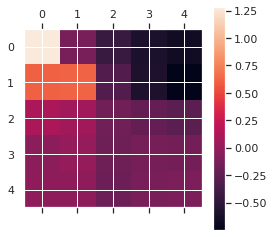

([24, 41, 15, 1, 40], [24, 41, 0, 0, 0], [24, 41, 0, 0, 0])

In [0]:
# For revision model 3
activation_model = Model(inputs=model.input, outputs=model.layers[-5].output, name="Activation_model")
activation_model.summary()

X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
activation = activation_model.predict(X, verbose=0)
yhat = model.predict(X, verbose=0)

fig = plt.matshow(activation[0])
plt.colorbar(fig)
plt.show()

one_hot_decode(X[0]), one_hot_decode(y[0]), one_hot_decode(yhat[0])

# **Revision Self Attention Model 4 (5000 epochs)**

1.   Adjust the hidden neurons number of query, key and value's layers
2.   Concatenate the original input to the attention layer with the attention output (attention map)
3.   Add the layer normalization
4.   Same result as model 3

In [0]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]
 
# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)
 
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]
 
# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
	# generate random sequence
	sequence_in = generate_sequence(n_in, cardinality)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, cardinality)
	y = one_hot_encode(sequence_out, cardinality)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y
 
# train and evaluate a model, return accuracy
def train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs):
	# train LSTM
	for epoch in range(epochs):
		# generate new random sequence
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		# fit model for one epoch on this sequence
		model.fit(X, y, epochs=1, verbose=0)
	# evaluate LSTM
	total, correct = 100, 0
	for _ in range(total):
		X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
		yhat = model.predict(X, verbose=0)
		if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
			correct += 1
	return float(correct)/float(total)*100.0

In [0]:
# My own attention model
# define the encoder-decoder with attention model
def attention_model(n_timesteps_in, n_features):
 input_ = Input(shape=(n_timesteps_in, n_features))
 x = LSTM(150, return_sequences=True)(input_)

 # Create query, key, value for self-attention computation
 # Conv1D with kernel_size 1 is equal to Dense
 query = Conv1D(filters=75, kernel_size=1, activation="relu", strides=1)(x)
 key = Conv1D(filters=75, kernel_size=1, activation="relu", strides=1)(x)
 value = Conv1D(filters=150, kernel_size=1, activation="relu", strides=1)(x)
 # Dot product query and key - the query_key's size should be (timesteps * timesteps)
 # axes: indicate the axes to multiply with the other tensor
 query_key = Dot(axes=2, normalize=True)([query,key]) 
 # Softmax is applied across the columns to find the attention of one timestep to the others
 # The attention's size should be (timesteps * timesteps)
 attention = Activation("softmax")(query_key)
 attention = LayerNormalization()(attention)
 content_vector = Dot(axes=1, normalize=True, name="reg_dot2")([attention,value])
 content_vector = concatenate([x,content_vector])
 output_ = Dense(n_features, activation="softmax")(content_vector)

 model = Model(inputs=input_, outputs=output_)
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
n_repeats = 5
epochs = 5000

# evaluate encoder-decoder with attention model
print('Encoder-Decoder With Attention Model')
results = list()
for i in range(n_repeats):
  model = attention_model(n_timesteps_in, n_features)
  if i == 0:
    model.summary()
  accuracy = train_evaluate_model(model, n_timesteps_in, n_timesteps_out, n_features, epochs)
  results.append(accuracy)
  print(accuracy)
print('Mean Accuracy: %.2f%%' % (sum(results)/float(n_repeats)))

Encoder-Decoder With Attention Model
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 5, 50)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 5, 150)       120600      input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 5, 75)        11325       lstm_6[0][0]                     
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 5, 75)        11325       lstm_6[0][0]                     
_______________________________________________________

**Activation Map Visualization**

Model: "Activation_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 5, 50)]      0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 5, 150)       120600      input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 5, 75)        11325       lstm_10[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 5, 75)        11325       lstm_10[0][0]                    
___________________________________________________________________________________

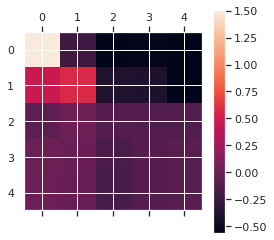

([20, 11, 47, 2, 21], [20, 11, 0, 0, 0], [20, 11, 0, 0, 0])

In [0]:
# For revision model 4
activation_model = Model(inputs=model.input, outputs=model.layers[-5].output, name="Activation_model")
activation_model.summary()

X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
activation = activation_model.predict(X, verbose=0)
yhat = model.predict(X, verbose=0)

fig = plt.matshow(activation[0])
plt.colorbar(fig)
plt.show()

one_hot_decode(X[0]), one_hot_decode(y[0]), one_hot_decode(yhat[0])